In [1]:
# All the basic libraries
import pandas as pd
import numpy as np
import pulp
from pulp import *

# Maximum rows
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

### Importing Data

In [2]:
# Import distances and adjacent counties
distances = pd.read_csv('distances.csv')
adjacent = pd.read_csv('adjacent_counties.csv')
adjacent.head()

County1  Number1 County2  Number2
0   Allen    18003   Adams    18001
1     Jay    18075   Adams    18001
2   Wells    18179   Adams    18001
3   Adams    18001   Allen    18003
4  DeKalb    18033   Allen    18003

In [3]:
# Population demographics
popdemo = pd.read_csv('indiana_popdata.csv')
popdemo.head()

State              County  Pop2023  White %  Other %  TwoOrMore %  Black %  \
0    IN        Adams County    36235   0.9541   0.0189       0.0135   0.0099   
1    IN        Allen County   394434   0.7754   0.0226       0.0444   0.1135   
2    IN  Bartholomew County    83831   0.8362   0.0305       0.0346   0.0790   
3    IN       Benton County     8677   0.9689   0.0023       0.0205   0.0058   
4    IN    Blackford County    11917   0.9707   0.0000       0.0192   0.0044   

   Asian %  Indian %  Hawaiian %  
0   0.0026    0.0010      0.0000  
1   0.0418    0.0020      0.0004  
2   0.0185    0.0012      0.0000  
3   0.0008    0.0002      0.0015  
4   0.0033    0.0024      0.0000

In [4]:
# Indiana Data
indiana_data = pd.read_csv('indiana_data.csv')
indiana_data['countynum'] = list(range(0,92))
indiana_data['FIPS code']=indiana_data['FIPS code']+18000
indiana_data.head(50)

County  FIPS code     County seat  Population  Area  Trump votes  \
0         Adams      18001         Decatur       36068   339        10686   
1         Allen      18003      Fort Wayne      391449   657        92083   
2   Bartholomew      18005        Columbus       83540   407        22410   
3        Benton      18007          Fowler        8719   406         3007   
4     Blackford      18009   Hartford City       11919   165         3841   
5         Boone      18011         Lebanon       74164   423        22351   
6         Brown      18013       Nashville       15570   312         5777   
7       Carroll      18015          Delphi       20555   372         7086   
8          Cass      18017      Logansport       37540   412        10552   
9         Clark      18019  Jeffersonville      124237   373        33668   
10         Clay      18021          Brazil       26379   358         9499   
11      Clinton      18023       Frankfort       32843   405         9334   
12     Crawford      18025         English       10536   306         3483   
13      Daviess      18027      Washington       33418   429         9576   
14     Dearborn      18029    Lawrenceburg       51138   305        19528   
15      Decatur      18031      Greensburg       26416   373         9575   
16       DeKalb      18033          Auburn       43731   363        14237   
17     Delaware      18035          Muncie      112031   392        26827   
18       Dubois      18037          Jasper       43632   427        15033   
19      Elkhart      18039          Goshen      206890   463        46972   
20      Fayette      18041    Connersville       23349   215         7755   
21        Floyd      18043      New Albany       80714   148        23400   
22     Fountain      18045       Covington       16574   396         6154   
23     Franklin      18047      Brookville       23028   384         9691   
24       Fulton      18049       Rochester       20327   368         6694   
25       Gibson      18051       Princeton       32993   487        11817   
26        Grant      18053          Marion       66022   414        18543   
27       Greene      18055      Bloomfield       31006   543        11103   
28     Hamilton      18057     Noblesville      364921   394       101587   
29      Hancock      18059      Greenfield       83070   306        28996   
30     Harrison      18061         Corydon       39851   485        14565   
31    Hendricks      18063        Danville      182534   407        53802   
32        Henry      18065      New Castle       48915   392        15043   
33       Howard      18067          Kokomo       83574   293        26449   
34   Huntington      18069      Huntington       36834   383        13147   
35      Jackson      18071      Brownstown       46300   509        14555   
36       Jasper      18073      Rensselaer       33281   560        11383   
37          Jay      18075        Portland       20198   384         6361   
38    Jefferson      18077         Madison       32946   361         9663   
39     Jennings      18079          Vernon       27536   377         9490   
40      Johnson      18081        Franklin      165782   320        51219   
41         Knox      18083       Vincennes       35789   516        11655   
42    Kosciusko      18085          Warsaw       80826   531        26499   
43     LaGrange      18087        LaGrange       40866   380         8110   
44         Lake      18089     Crown Point      499689   499        91760   
45      LaPorte      18091         LaPorte      111675   598        25997   
46     Lawrence      18093         Bedford       45222   449        15601   
47      Madison      18095        Anderson      131744   452        31215   
48       Marion      18097    Indianapolis      969466   396       134175   
49     Marshall      18099        Plymouth       46332   444        13844   

   Trump pct  Biden votes Biden pct  \
0      75.2%         3236     22.8%   
1  

### Modeling

In [5]:
# Create the linear programming model.
model = LpProblem("Set Partition", LpMinimize) 

# 92 counties and 9 districts
n_counties = 92
n_districts = 9
variable_names = [str(i)+str(j) for j in range(1, n_districts+1) \
                                for i in range(1, n_counties+1)]

# Sort the names
variable_names.sort()

/Users/bradenwellman/opt/anaconda3/lib/python3.8/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [6]:
# Decision variable. Binary to 1 of 9 counties. 1 if included, 0 if not
DV_variable_y = LpVariable.matrix("Y", variable_names, cat="Binary")

# Assign and print
assignment = np.array(DV_variable_y).reshape(92,9)
print(assignment[0])

[Y_101 Y_102 Y_103 Y_104 Y_105 Y_106 Y_107 Y_108 Y_109]


In [7]:
# The Decision Variable X is the population allocated to the district
DV_variable_x = LpVariable.matrix("X", variable_names, cat="Integer",
                                  lowBound=0)

# Allocate
allocation = np.array(DV_variable_x).reshape(92,9)

#Creating a matrix of distances between counties
dist=np.zeros((92,92))

# Loop through counties
for i in range(n_counties):
    
    # Loop through distances
    for k in range(distances.shape[0]):
        
        # Make all of the assignments
        if indiana_data['FIPS code'][i]==distances['County 2'][k]:
            for j in range(n_counties):
                if distances['County 1'][k]==indiana_data['FIPS code'][j]:
                    dist[j][i]=distances['distance'][k]

In [8]:
# Check shape
dist=np.tril(dist,-1)
dist.shape

(92, 92)

In [9]:
# Check Shape
assignment.shape

(92, 9)

### Objective Function

In [10]:
# districts3: the objective function

# This objective minimizes the total inter county distance within a district
objective_function = lpSum(np.transpose(assignment)@dist) 
model += objective_function

### Constraints

In [11]:
# Allocate 100% of the population from each county.
for i in range(n_counties):
    model += lpSum(allocation[i][j] for j in range(n_districts)) == indiana_data['Population'][i] , "Allocate All " + str(i)

In [12]:
# County populations 
county_populations=indiana_data['Population']

#This constraint makes assignment required for allocation.
for i in range(n_counties): 
    for j in range(n_districts):
        model += allocation[i][j] <= sum(county_populations)*assignment[i][j] \
                 , "Allocation assignment " + str(i) + str(j)
        if assignment[i][j] == 1:
            
            # 100 % of the population
            model += allocation[i][j] >= assignment[i][j]*1.00*county_populations[i] \
                     , "Allocation min " + str(i) + str(j)

In [13]:
# Contiguous districts constraints

# e.g. Coos County (5) borders only Curry County (7) or Douglas County (8)
#      Therefore at least (7) or (8) need to be allocated to any district that has (5)

# *a 2 in front of the left hand side means the county is required to border at least two counties from the same district

# Loop through all the districts
for j in range(n_districts):
    model += 1*assignment[0][j] <= assignment[37][j]+assignment[89][j]+assignment[1][j]
    model += 3*assignment[1][j] <= assignment[0][j]+assignment[16][j]+assignment[34][j]+assignment[56][j] +assignment[89][j]+assignment[91][j]
    model += 3*assignment[2][j] <= assignment[6][j]+assignment[15][j]+assignment[35][j]+assignment[39][j]+assignment[40][j]+assignment[71][j]
    model += 2*assignment[3][j] <= assignment[36][j]+assignment[55][j]+assignment[78][j]+assignment[85][j]+assignment[90][j]   
    model += 2*assignment[4][j] <= assignment[17][j]+assignment[26][j]+assignment[37][j]+assignment[89][j] 
    model += 2*assignment[5][j] <= assignment[11][j]+assignment[28][j]+assignment[31][j]+assignment[48][j]+assignment[53][j]    
    model += 2*assignment[6][j] <= assignment[35][j]+assignment[40][j]+assignment[52][j]+assignment[54][j]
    model += 2*assignment[7][j] <= assignment[8][j]+assignment[11][j]+assignment[33][j]+assignment[78][j]+assignment[90][j]   
    model += 3*assignment[8][j] <= assignment[7][j]+assignment[24][j]+assignment[33][j]+assignment[51][j]+assignment[65][j]+assignment[90][j]
    model += 2*assignment[9][j] <= assignment[21][j]+assignment[38][j]+assignment[70][j]+assignment[87][j]
    model += 3*assignment[10][j] <= assignment[27][j]+assignment[59][j]+assignment[60][j]+assignment[66][j]+assignment[76][j]+assignment[83][j]
    model += 3*assignment[11][j] <= assignment[7][j]+assignment[28][j]+assignment[33][j]+assignment[53][j]+assignment[78][j]+assignment[79][j]
    model += 2*assignment[12][j] <= assignment[18][j]+assignment[30][j]+assignment[58][j]+assignment[61][j]+assignment[87][j]
    model += 2*assignment[13][j] <= assignment[18][j]+assignment[27][j]+assignment[41][j]+assignment[50][j]+assignment[62][j]
    model += 1*assignment[14][j] <= assignment[23][j]+assignment[57][j]+assignment[68][j]
    model += 3*assignment[15][j] <= assignment[2][j]+assignment[23][j]+assignment[39][j]+assignment[68][j]+assignment[69][j]+assignment[71][j]
    model += 1*assignment[16][j] <= assignment[1][j]+assignment[56][j]+assignment[75][j]
    model += 3*assignment[17][j] <= assignment[4][j]+assignment[26][j]+assignment[32][j]+assignment[37][j]+assignment[47][j]+assignment[67][j]
    model += 4*assignment[18][j] <= assignment[12][j]+assignment[13][j]+assignment[50][j]+assignment[58][j]+assignment[61][j]+assignment[62][j]+assignment[72][j]+assignment[86][j]
    model += 2*assignment[19][j] <= assignment[42][j]+assignment[43][j]+assignment[49][j]+assignment[56][j]+assignment[73][j]
    model += 2*assignment[20][j] <= assignment[23][j]+assignment[32][j]+assignment[69][j]+assignment[80][j]+assignment[88][j]
    model += 1*assignment[21][j] <= assignment[9][j]+assignment[30][j]+assignment[87][j]
    model += 2*assignment[22][j] <= assignment[53][j]+assignment[60][j]+assignment[78][j]+assignment[82][j]+assignment[85][j]
    model += 3*assignment[23][j] <= assignment[14][j]+assignment[15][j]+assignment[20][j]+assignment[68][j]+assignment[69][j]+assignment[80][j]
    model += 3*assignment[24][j] <= assignment[8][j]+assignment[42][j]+assignment[49][j]+assignment[51][j]+assignment[65][j]+assignment[74][j]+assignment[84][j]
    model += 2*assignment[25][j] <= assignment[41][j]+assignment[62][j]+assignment[64][j]+assignment[81][j]+assignment[86][j]
    model += 4*assignment[26][j] <= assignment[4][j]+assignment[17][j]+assignment[33][j]+assignment[34][j]+assignment[47][j]+assignment[51][j]+assignment[79][j]+assignment[89][j]+assignment[84][j]
    model += 4*assignment[27][j] <= assignment[10][j]+assignment[13][j]+assignment[41][j]+assignment[46][j]+assignment[50][j]+assignment[52][j]+assignment[59][j]+assignment[76][j]
    model += 3*assignment[28][j] <= assignment[5][j]+assignment[11][j]+assignment[29][j]+assignment[47][j]+assignment[48][j]+assignment[79][j]
    model += 3*assignment[29][j] <= assignment[28][j]+assignment[32][j]+assignment[47][j]+assignment[48][j]+assignment[69][j]+assignment[71][j]
    model += 2*assignment[30][j] <= assignment[12][j]+assignment[21][j]+assignment[87][j]
    model += 2*assignment[31][j] <= assignment[5][j]+assignment[48][j]+assignment[53][j]+assignment[54][j]+assignment[66][j]
    model += 3*assignment[32][j] <= assignment[17][j]+assignment[20][j]+assignment[29][j]+assignment[47][j]+assignment[67][j]+assignment[69][j]+assignment[88][j]
    model += 3*assignment[33][j] <= assignment[7][j]+assignment[8][j]+assignment[11][j]+assignment[26][j]+assignment[51][j]+assignment[79][j]
    model += 2*assignment[34][j] <= assignment[1][j]+assignment[26][j]+assignment[84][j]+assignment[89][j]+assignment[91][j]
    model += 3*assignment[35][j] <= assignment[2][j]+assignment[6][j]+assignment[39][j]+assignment[46][j]+assignment[52][j]+assignment[70][j]+assignment[87][j]
    model += 4*assignment[36][j] <= assignment[3][j]+assignment[44][j]+assignment[45][j]+assignment[55][j]+assignment[63][j]+assignment[65][j]+assignment[74][j]+assignment[90][j] 
    model += 2*assignment[37][j] <= assignment[0][j]+assignment[4][j]+assignment[17][j]+assignment[67][j]+assignment[89][j] 
    model += 2*assignment[38][j] <= assignment[9][j]+assignment[39][j]+assignment[68][j]+assignment[70][j]+assignment[77][j]
    model += 3*assignment[39][j] <= assignment[2][j]+assignment[15][j]+assignment[35][j]+assignment[38][j]+assignment[68][j]+assignment[70][j] 
    model += 2*assignment[40][j] <= assignment[2][j]+assignment[6][j]+assignment[48][j]+assignment[54][j]+assignment[71][j]
    model += 2*assignment[41][j] <= assignment[13][j]+assignment[25][j] +assignment[27][j]+assignment[62][j]+assignment[76][j]
    model += 3*assignment[42][j] <= assignment[19][j]+assignment[24][j]+assignment[49][j]+assignment[56][j]+assignment[84][j]+assignment[91][j]
    model += 1*assignment[43][j] <= assignment[19][j]+assignment[56][j]+assignment[75][j]
    model += 1*assignment[44][j] <= assignment[36][j]+assignment[55][j]+assignment[63][j]
    model += 2*assignment[45][j] <= assignment[36][j]+assignment[63][j]+assignment[73][j]
    model += 3*assignment[46][j] <= assignment[27][j]+assignment[35][j]+assignment[50][j]+assignment[52][j]+assignment[58][j]+assignment[87][j]
    model += 3*assignment[47][j] <= assignment[17][j]+assignment[26][j]+assignment[28][j]+assignment[29][j]+assignment[32][j]+assignment[79][j]
    model += 3*assignment[48][j] <= assignment[5][j]+assignment[28][j]+assignment[29][j]+assignment[31][j]+assignment[40][j]+assignment[54][j]+assignment[71][j]
    model += 3*assignment[49][j] <= assignment[19][j]+assignment[24][j]+assignment[42][j]+assignment[65][j]+assignment[73][j]+assignment[74][j]
    model += 2*assignment[50][j] <= assignment[13][j]+assignment[18][j]+assignment[27][j]+assignment[46][j]+assignment[58][j]
    model += 2*assignment[51][j] <= assignment[8][j]+assignment[24][j]+assignment[26][j]+assignment[33][j]+assignment[84][j]
    model += 3*assignment[52][j] <= assignment[6][j]+assignment[27][j]+assignment[35][j]+assignment[46][j]+assignment[54][j]+assignment[59][j]
    model += 3*assignment[53][j] <= assignment[5][j]+assignment[11][j]+assignment[22][j]+assignment[31][j]+assignment[60][j]+assignment[66][j]+assignment[78][j]
    model += 3*assignment[54][j] <= assignment[5][j]+assignment[31][j]+assignment[40][j]+assignment[48][j]+assignment[52][j]+assignment[59][j]+assignment[66][j]
    model += 1*assignment[55][j] <= assignment[3][j]+assignment[36][j]+assignment[44][j]
    model += 3*assignment[56][j] <= assignment[1][j]+assignment[16][j]+assignment[19][j]+assignment[42][j]+assignment[43][j]+assignment[91][j]
    model += 2*assignment[57][j] <= assignment[14][j]+assignment[68][j]+assignment[77][j]
    model += 2*assignment[58][j] <= assignment[12][j]+assignment[18][j]+assignment[46][j]+assignment[50][j]+assignment[87][j]
    model += 2*assignment[59][j] <= assignment[10][j]+assignment[27][j]+assignment[52][j]+assignment[54][j]+assignment[66][j]
    model += 3*assignment[60][j] <= assignment[10][j]+assignment[22][j]+assignment[53][j]+assignment[66][j]+assignment[82][j]+assignment[83][j]
    model += 2*assignment[61][j] <= assignment[12][j]+assignment[18][j]+assignment[72][j]
    model += 2*assignment[62][j] <= assignment[13][j]+assignment[18][j]+assignment[25][j]+assignment[41][j]+assignment[86][j]
    model += 2*assignment[63][j] <= assignment[36][j]+assignment[44][j]+assignment[45][j]+assignment[74][j]
    model += 1*assignment[64][j] <= assignment[25][j]+assignment[81][j]
    model += 3*assignment[65][j] <= assignment[8][j]+assignment[24][j]+assignment[36][j]+assignment[49][j]+assignment[74][j]+assignment[90][j]
    model += 3*assignment[66][j] <= assignment[10][j]+assignment[31][j]+assignment[53][j]+assignment[54][j]+assignment[59][j]+assignment[60][j]
    model += 2*assignment[67][j] <= assignment[17][j]+assignment[32][j]+assignment[37][j]+assignment[88][j]
    model += 3*assignment[68][j] <= assignment[14][j]+assignment[15][j]+assignment[23][j]+assignment[38][j]+assignment[39][j]+assignment[57][j]+assignment[77][j]
    model += 3*assignment[69][j] <= assignment[15][j]+assignment[20][j]+assignment[23][j]+assignment[29][j]+assignment[32][j]+assignment[71][j]
    model += 2*assignment[70][j] <= assignment[19][j]+assignment[45][j]+assignment[49][j]+assignment[74][j]
    model += 2*assignment[71][j] <= assignment[9][j]+assignment[35][j]+assignment[38][j]+assignment[39][j]+assignment[87][j]
    model += 3*assignment[72][j] <= assignment[2][j]+assignment[15][j]+assignment[29][j]+assignment[40][j]+assignment[48][j]+assignment[69][j]
    model += 1*assignment[73][j] <= assignment[18][j]+assignment[61][j]+assignment[86][j] 
    model += 3*assignment[74][j] <= assignment[24][j]+assignment[36][j]+assignment[45][j]+assignment[49][j]+assignment[63][j]+assignment[65][j]+assignment[73][j]
    model += 1*assignment[75][j] <= assignment[16][j]+assignment[43][j]
    model += 2*assignment[76][j] <= assignment[10][j]+assignment[27][j]+assignment[41][j]+assignment[83][j]
    model += 2*assignment[77][j] <= assignment[38][j]+assignment[57][j]+assignment[68][j]
    model += 3*assignment[78][j] <= assignment[3][j]+assignment[7][j]+assignment[11][j]+assignment[22][j]+assignment[53][j]+assignment[85][j]+assignment[90][j]
    model += 2*assignment[79][j] <= assignment[11][j]+assignment[26][j]+assignment[28][j]+assignment[33][j]+assignment[47][j]
    model += 1*assignment[80][j] <= assignment[20][j]+assignment[23][j]+assignment[88][j]
    model += 1*assignment[81][j] <= assignment[25][j]+assignment[64][j]+assignment[86][j]
    model += 2*assignment[82][j] <= assignment[22][j]+assignment[60][j]+assignment[83][j]+assignment[85][j]
    model += 2*assignment[83][j] <= assignment[10][j]+assignment[60][j]+assignment[76][j]+assignment[82][j]
    model += 3*assignment[84][j] <= assignment[24][j]+assignment[26][j]+assignment[34][j]+assignment[42][j]+assignment[51][j]+assignment[91][j]
    model += 1*assignment[85][j] <= assignment[3][j]+assignment[22][j]+assignment[78][j]
    model += 2*assignment[86][j] <= assignment[18][j]+assignment[25][j]+assignment[62][j]+assignment[72][j]+assignment[81][j]
    model += 4*assignment[87][j] <= assignment[9][j]+assignment[12][j]+assignment[21][j]+assignment[30][j]+assignment[35][j]+assignment[46][j]+assignment[58][j]+assignment[70][j] 
    model += 2*assignment[88][j] <= assignment[20][j]+assignment[32][j]+assignment[67][j]+assignment[80][j]
    model += 3*assignment[89][j] <= assignment[0][j]+assignment[1][j]+assignment[4][j]+assignment[26][j]+assignment[34][j]+assignment[37][j]
    model += 3*assignment[90][j] <= assignment[3][j]+assignment[7][j]+assignment[8][j]+assignment[36][j]+assignment[65][j]+assignment[78][j]
    model += 2*assignment[91][j] <= assignment[1][j]+assignment[34][j]+assignment[42][j]+assignment[56][j]+assignment[84][j]

In [14]:
# Improvement Assignment / Allocation Constraints (sometimes known as cuts)

# Pairs of counties that are far apart geographically with population centers in between them
for j in range(n_districts):
   
    # North counties not to be assigned to the South beyond population centers in the middle
    model += assignment[44][j] + assignment[64][j] <= 1 
    model += assignment[44][j] + assignment[81][j] <= 1
    model += assignment[44][j] + assignment[86][j] <= 1
    model += assignment[44][j] + assignment[72][j] <= 1
    model += assignment[44][j] + assignment[61][j] <= 1
    model += assignment[44][j] + assignment[30][j] <= 1
    model += assignment[44][j] + assignment[21][j] <= 1
    model += assignment[44][j] + assignment[62][j] <= 1
    model += assignment[44][j] + assignment[25][j] <= 1
    model += assignment[44][j] + assignment[12][j] <= 1
    model += assignment[44][j] + assignment[18][j] <= 1
   
        
    model += assignment[45][j] + assignment[64][j] <= 1 
    model += assignment[45][j] + assignment[81][j] <= 1
    model += assignment[45][j] + assignment[86][j] <= 1
    model += assignment[45][j] + assignment[72][j] <= 1
    model += assignment[45][j] + assignment[61][j] <= 1
    model += assignment[45][j] + assignment[30][j] <= 1
    model += assignment[45][j] + assignment[21][j] <= 1
    model += assignment[45][j] + assignment[62][j] <= 1
    model += assignment[45][j] + assignment[25][j] <= 1
    model += assignment[45][j] + assignment[12][j] <= 1
    model += assignment[45][j] + assignment[18][j] <= 1
    
    model += assignment[63][j] + assignment[64][j] <= 1 
    model += assignment[63][j] + assignment[81][j] <= 1
    model += assignment[63][j] + assignment[86][j] <= 1
    model += assignment[63][j] + assignment[72][j] <= 1
    model += assignment[63][j] + assignment[61][j] <= 1
    model += assignment[63][j] + assignment[30][j] <= 1
    model += assignment[63][j] + assignment[21][j] <= 1
    model += assignment[63][j] + assignment[62][j] <= 1
    model += assignment[63][j] + assignment[25][j] <= 1
    model += assignment[63][j] + assignment[12][j] <= 1
    model += assignment[63][j] + assignment[18][j] <= 1
    
    model += assignment[43][j] + assignment[64][j] <= 1 
    model += assignment[43][j] + assignment[81][j] <= 1
    model += assignment[43][j] + assignment[86][j] <= 1
    model += assignment[43][j] + assignment[72][j] <= 1
    model += assignment[43][j] + assignment[61][j] <= 1
    model += assignment[43][j] + assignment[30][j] <= 1
    model += assignment[43][j] + assignment[21][j] <= 1
    model += assignment[43][j] + assignment[62][j] <= 1
    model += assignment[43][j] + assignment[25][j] <= 1
    model += assignment[43][j] + assignment[12][j] <= 1
    model += assignment[43][j] + assignment[18][j] <= 1
    
    model += assignment[19][j] + assignment[64][j] <= 1 
    model += assignment[19][j] + assignment[81][j] <= 1
    model += assignment[19][j] + assignment[86][j] <= 1
    model += assignment[19][j] + assignment[72][j] <= 1
    model += assignment[19][j] + assignment[61][j] <= 1
    model += assignment[19][j] + assignment[30][j] <= 1
    model += assignment[19][j] + assignment[21][j] <= 1
    model += assignment[19][j] + assignment[62][j] <= 1
    model += assignment[19][j] + assignment[25][j] <= 1
    model += assignment[19][j] + assignment[12][j] <= 1
    model += assignment[19][j] + assignment[18][j] <= 1

    model += assignment[75][j] + assignment[64][j] <= 1 
    model += assignment[75][j] + assignment[81][j] <= 1
    model += assignment[75][j] + assignment[86][j] <= 1
    model += assignment[75][j] + assignment[72][j] <= 1
    model += assignment[75][j] + assignment[61][j] <= 1
    model += assignment[75][j] + assignment[30][j] <= 1
    model += assignment[75][j] + assignment[21][j] <= 1
    model += assignment[75][j] + assignment[62][j] <= 1
    model += assignment[75][j] + assignment[25][j] <= 1
    model += assignment[75][j] + assignment[12][j] <= 1
    model += assignment[75][j] + assignment[18][j] <= 1

    model += assignment[44][j] + assignment[19][j] <= 1
    model += assignment[83][j] + assignment[17][j] <=1
    model += assignment[48][j] + assignment[21][j] <=1
    model += assignment[43][j] + assignment[45][j] <=1
    model += assignment[38][j] + assignment[12][j] <=1
    model += assignment[43][j] + assignment[16][j] <=1

    model += assignment[73][j] + assignment[64][j] <= 1
    model += assignment[73][j] + assignment[30][j] <= 1
    model += assignment[73][j] + assignment[21][j] <= 1
    model += assignment[73][j] + assignment[62][j] <= 1
    model += assignment[73][j] + assignment[25][j] <= 1
    model += assignment[73][j] + assignment[12][j] <= 1
    model += assignment[73][j] + assignment[18][j] <= 1

In [15]:
# Population in District constraints, in order to keep the size of districts by population similar
for j in range(n_districts):
    model += lpSum(allocation[i][j] for i in range(n_counties)) <= 764000*5 , "District Size Maximum " + str(j)
    model += lpSum(allocation[i][j] for i in range(n_counties)) >= 764000*0.05 , "District Size Minimum " + str(j)

In [16]:
# More demographic constraints
population = indiana_data['Population']
votes= indiana_data['Trump votes']
demowhite = popdemo['White %']
demowhitepop = demowhite*population

# Loop through
for i in range(n_counties):
    int(demowhitepop[i])

In [17]:
# Political percent constraints where votes are ~20-80% in each district based on county assignment
# for j in range(n_districts):
#     model += (np.transpose(assignment)@votes)[j] >=0.25*(np.transpose(assignment)@population)[j]
#     model += (np.transpose(assignment)@votes)[j] <=0.75*(np.transpose(assignment)@population)[j]

# Demographic constraints where white% is at least 68% and less than the average of 97%
# for j in range(n_districts):
#     model += (np.transpose(assignment)@demowhite)[j] >=0.1*(np.transpose(assignment)@population)[j]
#     model += (np.transpose(assignment)@demowhite)[j] <=0.97*(np.transpose(assignment)@population)[j]

In [18]:
# Number of counties in each district constraint
for j in range(n_districts):
    model += lpSum(assignment[i][j] for i in range(n_counties)) >= 3 , "CDistrict Num Min " + str(j)
    model += lpSum(assignment[i][j] for i in range(n_counties)) <= 23 , "CDistrict Num Max " + str(j)

In [19]:
# Actually Solve the Problem
model.solve()
print('The model status is: ',LpStatus[model.status])
print('The objective value is: ', value(objective_function))

The model status is:  Optimal
The objective value is:  448506.08522488305


### Results

In [20]:
# List of results
result_value = []

# Loop through counties and districts
for i in range(n_counties):
    for j in range(n_districts):
        
        # If assignment is not zero...
        if int(assignment[i][j].value()*(j+1))!=0:
            
            # This is the output
            var_output = {
            'County': indiana_data['County'][i],
            'District': j+1,
            'Assignment': int(assignment[i][j].value()*(j+1)),
            'Allocation': allocation[i][j].value()}
            result_value.append(var_output)

# Results
results = pd.DataFrame(result_value)
results

County  District  Assignment  Allocation
0         Adams         7           7     36068.0
1         Allen         7           7    391449.0
2   Bartholomew         2           2     83540.0
3        Benton         3           3      8719.0
4     Blackford         5           5     11919.0
..          ...       ...         ...         ...
87   Washington         4           4     28224.0
88        Wayne         9           9     66273.0
89        Wells         7           7     28335.0
90        White         8           8     24598.0
91      Whitley         5           5     34627.0

[92 rows x 4 columns]

### Graphing

<ipython-input-21-7336f3ba35ee>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counties['category'][j]= results['District'][i]


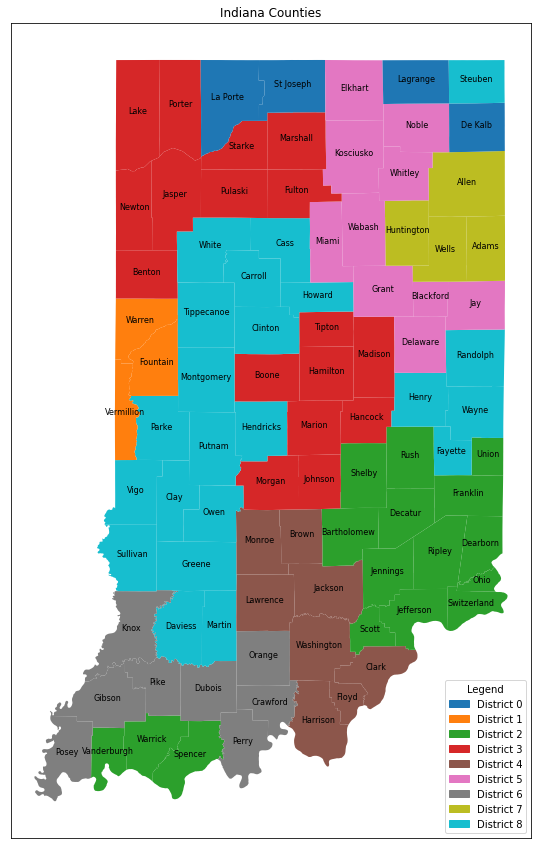

In [21]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# Load, randomly assign each county to one of nine districts
counties = gpd.read_file('Bounds.geojson')
categories = np.random.choice(9, size=len(counties))

counties['category']=0

for i in range(n_counties):
    for j in range(n_counties):
        if results['County'][i]== counties['name'][j]:
            counties['category'][j]= results['District'][i]
# Plot
cmap = plt.cm.get_cmap('tab10', 9)
fig, ax = plt.subplots(figsize=(12, 15))
counties.plot(ax=ax, column='category', cmap=cmap, legend=False)

# Add county names
for idx, row in counties.iterrows():
    ax.annotate(text=row['name'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=8)

# Title
ax.set_title('Indiana Counties')

# Legendegend
handles, labels = [], []
for i in range(9):
    label = f"District {i}"
    color = cmap(i)
    handles.append(plt.Rectangle((0, 0), 1, 1, color=color))
    labels.append(label)
plt.legend(handles, labels, loc='lower right', title='Legend')

# Remove x and y labels
ax.set_xticks([])
ax.set_yticks([])

# Show
plt.show()

In [22]:
import folium

# Random colors
cmap = folium.LinearColormap(colors=['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a',
                                     '#b15928', '#a6cee3', '#b2df8a', '#fb9a99'], 
                             vmin=0, vmax=8)

# Create map
counties['category'] = np.random.choice(9, size=len(counties))
counties['category']=0

for i in range(n_counties):
    for j in range(n_counties):
        if results['County'][i]== counties['name'][j]:
            counties['category'][j]= results['District'][i]

county_map = folium.Map(location=[39.79, -86.14], zoom_start=7)

# For annotating the different names
tooltip = folium.GeoJsonTooltip(fields=['name'], aliases=['County: '], sticky=False, style="font-size: 12px;")

# Add the county boundaries to the map
folium.GeoJson(counties,
               style_function=lambda feature: {
                   'fillColor': cmap(feature['properties']['category']),
                   'color': 'grey',
                   'weight': 0.5,
                   'fillOpacity': 0.6
               },
               tooltip=tooltip
              ).add_to(county_map)

# Colorbar and show
cmap.caption = 'County categories'
county_map.add_child(cmap)
county_map

<ipython-input-22-08b6685c4b1d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counties['category'][j]= results['District'][i]
